# Random Forest GNN in Chemistry

Sofia Blyufer 321128019

## Environment Setup

In [2]:
# !pip install --pre deepchem[tensorflow]
# !pip install torch_geometric
# !pip install dgllife
# !pip install dgl
!pip uninstall -y torch torch_geometric deepchem dgl dgllife

Found existing installation: torch 2.3.0+cu121
Uninstalling torch-2.3.0+cu121:
  Successfully uninstalled torch-2.3.0+cu121


In [3]:
!pip install torch==2.0.0
!pip install --pre deepchem[tensorflow]
!pip install torch_geometric
!pip install dgl==0.9.0
!pip install dgllife

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import deepchem as dc
from deepchem.models import DMPNNModel, GATModel
from deepchem.feat.graph_data import GraphData
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import dgl
from deepchem.models import GAT
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Datasets Used

In [6]:
loaded_data = []
names = []

### Tox21

In [7]:
# For DMPNN
tox21_tasks, tox21_datasets, tox21_transformers = dc.molnet.load_tox21(
    featurizer=dc.feat.DMPNNFeaturizer(features_generators=["rdkit_desc_normalized"]),
    splitter='scaffold'
)
loaded_data.append((tox21_tasks, tox21_datasets, tox21_transformers))
names.append('Tox21_DMPNN')

# For GAT
tox21_tasks, tox21_datasets, tox21_transformers = dc.molnet.load_tox21(
    featurizer=dc.feat.MolGraphConvFeaturizer(),
    splitter='scaffold'
)
loaded_data.append((tox21_tasks, tox21_datasets, tox21_transformers))
names.append('Tox21_GAT')

[16:42:09] WARNING: not removing hydrogen atom without neighbors
[16:42:09] WARNING: not removing hydrogen atom without neighbors
[16:50:25] WARNING: not removing hydrogen atom without neighbors
[16:50:35] WARNING: not removing hydrogen atom without neighbors
[16:51:42] WARNING: not removing hydrogen atom without neighbors


### BACE

In [8]:
# For DMPNN
BACE_tasks, BACE_datasets, BACE_transformers = dc.molnet.load_bace_classification(
    featurizer=dc.feat.DMPNNFeaturizer(features_generators=["rdkit_desc_normalized"]),
    splitter='scaffold'
)
loaded_data.append((BACE_tasks, BACE_datasets, BACE_transformers))
names.append('BACE_DMPNN')

# For GAT
BACE_tasks, BACE_datasets, BACE_transformers = dc.molnet.load_bace_classification(
    featurizer=dc.feat.MolGraphConvFeaturizer(),
    splitter='scaffold'
)
loaded_data.append((BACE_tasks, BACE_datasets, BACE_transformers))
names.append('BACE_GAT')

### ClinTox

In [9]:
# For DMPNN
clintox_tasks, clintox_datasets, clintox_transformers = dc.molnet.load_clintox(
    featurizer=dc.feat.DMPNNFeaturizer(features_generators=["rdkit_desc_normalized"]),
    splitter='scaffold'
)
loaded_data.append((clintox_tasks, clintox_datasets, clintox_transformers))
names.append('ClinTox_DMPNN')

# For GAT
clintox_tasks, clintox_datasets, clintox_transformers = dc.molnet.load_clintox(
    featurizer=dc.feat.MolGraphConvFeaturizer(),
    splitter='scaffold'
)
loaded_data.append((clintox_tasks, clintox_datasets, clintox_transformers))
names.append('ClinTox_GAT')

[16:54:11] Explicit valence for atom # 0 N, 5, is greater than permitted
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True)
[16:54:30] Can't kekulize mol.  Unkekulized atoms: 9
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True)
[16:55:38] Can't kekulize mol.  Unkekulized atoms: 4
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True)
[16:55:38] Can't kekulize mol.  Unkekulized atoms: 4
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:


### QM9

In [ ]:
# qm9_tasks, qm9_datasets, qm9_transformers = dc.molnet.load_qm9(
#     featurizer=dc.feat.DMPNNFeaturizer(features_generators=["rdkit_desc_normalized"]),
#     splitter='scaffold'
# )

# train_qm9, valid_qm9, test_qm9 = qm9_datasets

### R/S

In [7]:
RS_data = pd.read_pickle('/content/drive/MyDrive/RS_data/train_RS_classification_enantiomers_MOL_326865_55084_27542.pkl')
# RS_train, RS_test = train_test_split(RS_data, test_size=0.4)
# RS_valid, RS_test = train_test_split(RS_test, test_size=0.5)
RS_data, _ = train_test_split(RS_data, test_size = 0.8, shuffle = False)

# R/S requires custom loading
featurizer = dc.feat.DMPNNFeaturizer()

RS_data.head(10)

,ID,SMILES_nostereo,rdkit_mol_cistrans_stereo,RS_label,RS_label_binary
0,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x7969c19b6340>,S,1
1,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x7969c19b63e0>,S,1
2,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x7969c19b6480>,S,1
3,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x7969c19b6520>,S,1
4,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x7969c19b65c0>,S,1
5,BrC1=C[C@@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3cc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x7969c19b6660>,S,1
6,BrC1=C[C@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x7969c19b6700>,R,0
7,BrC1=C[C@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x7969c19b67a0>,R,0
8,BrC1=C[C@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x7969c19b6840>,R,0
9,BrC1=C[C@H](c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccc...,BrC1=CC(c2ccc(-c3ccccc3)cc2)CC(c2nc(-c3ccccc3)...,<rdkit.Chem.rdchem.Mol object at 0x7969c19b68e0>,R,0


In [8]:
# Featurize the dataset
# smiles = RS_data['SMILES_nostereo'].tolist()
smiles = RS_data['ID'].tolist()
features = featurizer.featurize(smiles)

# Check the first few features
print(features[:5])

[GraphData(node_features=[37, 133], edge_index=[2, 84], edge_features=[84, 14], global_features=[0])
 GraphData(node_features=[37, 133], edge_index=[2, 84], edge_features=[84, 14], global_features=[0])
 GraphData(node_features=[37, 133], edge_index=[2, 84], edge_features=[84, 14], global_features=[0])
 GraphData(node_features=[37, 133], edge_index=[2, 84], edge_features=[84, 14], global_features=[0])
 GraphData(node_features=[37, 133], edge_index=[2, 84], edge_features=[84, 14], global_features=[0])]


In [9]:
labels = RS_data['RS_label_binary'].values # R is 0 and S is 1

# Create a DeepChem Dataset to fit the input format
RS_dataset = dc.data.NumpyDataset(X=features, y=labels)
splitter = dc.splits.RandomSplitter()
RS_trainset, RS_validset, RS_testset = splitter.train_valid_test_split(RS_dataset)

In [11]:
check = pd.read_pickle('/content/drive/MyDrive/RS_data/test_RS_classification_enantiomers_MOL_69719_11680_5840.pkl')

In [12]:
check.head()

,ID,SMILES_nostereo,rdkit_mol_cistrans_stereo,RS_label,RS_label_binary
0,Br[C@@H]1SC=CN1C1CC1,BrC1SC=CN1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x7969aba1f560>,S,1
1,Br[C@@H]1SC=CN1C1CC1,BrC1SC=CN1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x7969aba1f600>,S,1
2,Br[C@@H]1SC=CN1C1CC1,BrC1SC=CN1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x7969bb26b1f0>,S,1
3,Br[C@H]1SC=CN1C1CC1,BrC1SC=CN1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x7969aba1f6f0>,R,0
4,Br[C@H]1SC=CN1C1CC1,BrC1SC=CN1C1CC1,<rdkit.Chem.rdchem.Mol object at 0x7969aba1f790>,R,0


## Baseline I

Here we would like to see what is the results of a basic GNN model on these datasets for baseline.

### DeepChem Datasets

In [93]:
results = []
for i, data in enumerate(loaded_data):
    tasks, datasets, transformers = data
    train, valid, test = datasets

    if 'DMPNN' in names[i]:
        baseline = DMPNNModel(
            n_tasks=len(tasks),
            n_classes=2,
            mode='classification',
            batch_size=50,
            global_features_size=200
        )
    elif 'GAT' in names[i]:
        baseline = GATModel(
            n_tasks=len(tasks),
            mode='classification',
            batch_size=50,
            learning_rate=0.001
        )

    baseline.fit(train, nb_epoch=30)

    metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
    test_score = baseline.evaluate(test, [metric], transformers)

    print(names[i])
    print("Test ROC-AUC Score:", test_score)
    results.append((names[i], test_score))

Tox21_DMPNN
Test ROC-AUC Score: {'roc_auc_score': 0.7194697390007955}
Tox21_GAT
Test ROC-AUC Score: {'roc_auc_score': 0.6907324533238137}
BACE_DMPNN
Test ROC-AUC Score: {'roc_auc_score': 0.8297101449275361}
BACE_GAT
Test ROC-AUC Score: {'roc_auc_score': 0.8083333333333333}
ClinTox_DMPNN
Test ROC-AUC Score: {'roc_auc_score': 0.9096957216835228}
ClinTox_GAT
Test ROC-AUC Score: {'roc_auc_score': 0.8614021826017447}


### External Datasets

In [ ]:
baseline_ = DMPNNModel(n_tasks = 1, \
                  n_classes=2, \
                  mode='classification', \
                  batch_size=50)
baseline_.fit(RS_trainset, nb_epoch=30)

# Evaluate the model on the validation set
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
valid_score = baseline_.evaluate(RS_validset, [metric])

print("R/S")
print("Validation ROC-AUC Score:", valid_score)

In [ ]:
results.append(("R/S", valid_score))

### Results

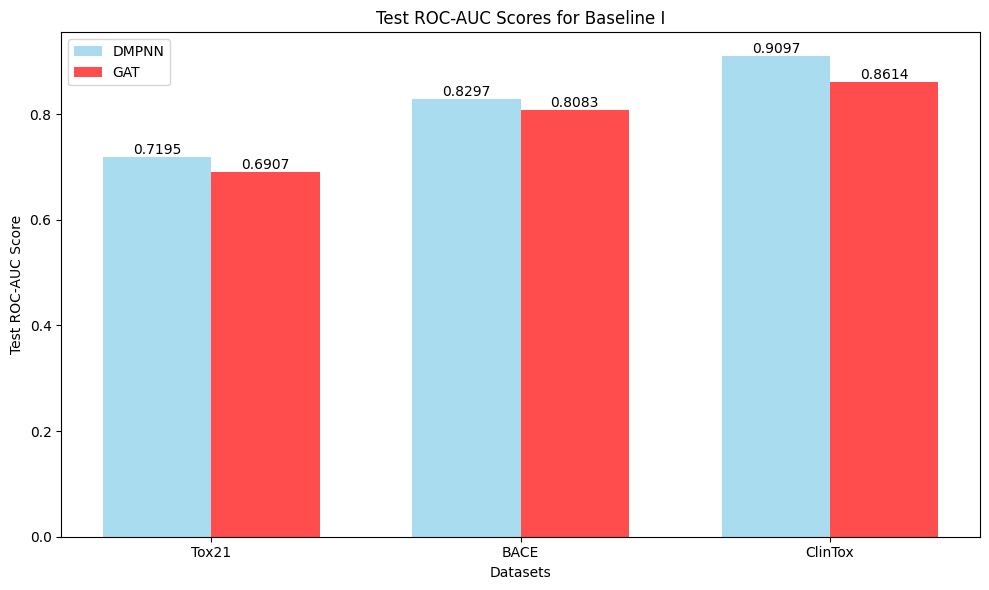

In [95]:
dataset_scores = {}
model_names = set()
for name, score in results:
    dataset_name = name.split('_')[0]
    model_name = name.split('_')[1]
    model_names.add(model_name)
    if dataset_name not in dataset_scores:
        dataset_scores[dataset_name] = {}
    dataset_scores[dataset_name][model_name] = score['roc_auc_score']

datasets = list(dataset_scores.keys())
dmpnn_scores = [dataset_scores[dataset]['DMPNN'] for dataset in datasets]
gat_scores = [dataset_scores[dataset]['GAT'] for dataset in datasets]

bar_width = 0.35
index = np.arange(len(datasets))

plt.figure(figsize=(10, 6))

bars1 = plt.bar(index, dmpnn_scores, bar_width, label='DMPNN', color='skyblue', alpha=0.7)
bars2 = plt.bar(index + bar_width, gat_scores, bar_width, label='GAT', color='r', alpha=0.7)

plt.xlabel('Datasets')
plt.ylabel('Test ROC-AUC Score')
plt.title('Test ROC-AUC Scores for Baseline I')
plt.xticks(index + bar_width / 2, datasets)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


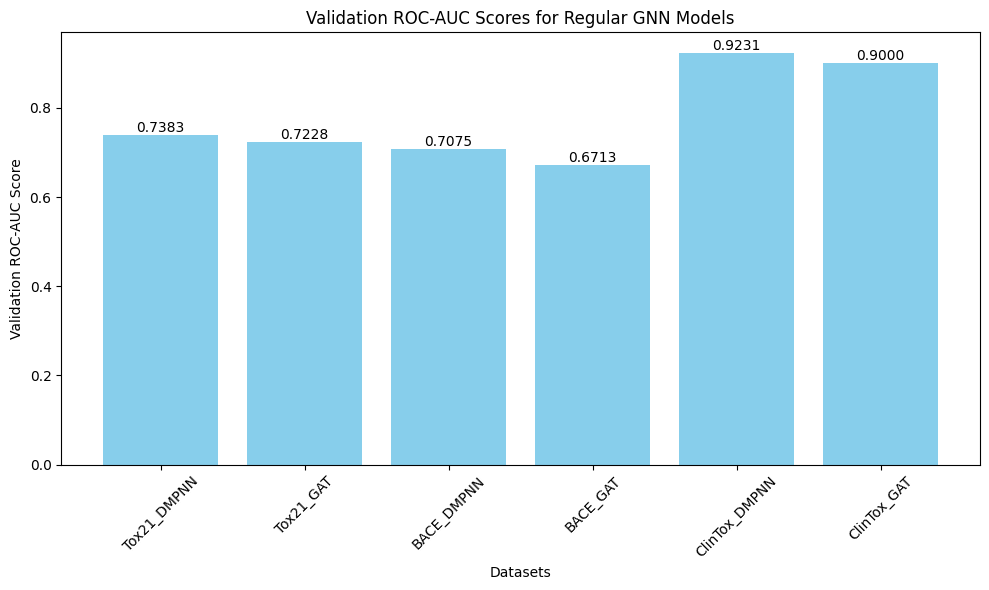

In [31]:
# # Extracting the names and their corresponding scores
# names_list = [result[0] for result in results]
# scores_list = [result[1]['roc_auc_score'] for result in results]

# # Plotting the results in a bar graph
# plt.figure(figsize=(10, 6))
# bars = plt.bar(names_list, scores_list, color='skyblue')
# plt.xlabel('Datasets')
# plt.ylabel('Validation ROC-AUC Score')
# plt.title('Validation ROC-AUC Scores for Regular GNN Models')
# plt.xticks(rotation=45)
# plt.tight_layout()

# for bar in bars:
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')


# # Display the plot
# plt.show()

## Baseline II

Here we check one improvement: we train a few base classifiers, each on a random fraction of the dataset. The prediction is based on the mean of all predictions of the different base classifiers.

In [10]:
def random_forest_predict_proba(X, models, n_tasks, labels):
  predictions = np.zeros((len(X), len(n_tasks), len(labels)))

  for model in models:
      model_predictions = model.predict(X)
      if model_predictions.ndim == 2:
          model_predictions = model_predictions.reshape(len(X), len(n_tasks), len(labels))
      predictions += model_predictions
  predictions /= len(models)

  return predictions

In [11]:
# currently binary
def cal_roc_auc_score(y_true, y_pred_prob):
  X, tasks, labels = y_pred_prob.shape
  score = 0
  for task in range(tasks):
    roc_auc = roc_auc_score(y_true[:,task], y_pred_prob[:, task, 1])
    score += roc_auc
  return score/tasks

In [82]:
num_models_options = [9, 10, 11, 12]
max_num_models = max(num_models_options)

results = []

for i, data in enumerate(loaded_data):
    tasks, datasets, transformers = data
    train, valid, test = datasets
    best_num_models = None
    best_valid_score = float('-inf')
    test_score = None

    models = []
    seed = 42
    frac_train = 0.6

    # Train the maximum number of models once
    for k in range(max_num_models):
        splitter = dc.splits.RandomSplitter()
        train_subset, _ = splitter.train_test_split(train, frac_train=frac_train, seed=seed + k)

        if 'DMPNN' in names[i]:
            model = dc.models.DMPNNModel(
                n_tasks=len(tasks),
                n_classes=2,
                mode='classification',
                batch_size=50,
                global_features_size=200
            )
        elif 'GAT' in names[i]:
            model = dc.models.GATModel(
                n_tasks=len(tasks),
                mode='classification',
                batch_size=50,
                learning_rate=0.001
            )

        model.fit(train_subset, nb_epoch=30)
        models.append(model)

    # This is to not waste and train again n+1 models
    for num_models in num_models_options:
        subset_models = models[:num_models]
        y_pred_proba = random_forest_predict_proba(valid, subset_models, tasks, np.unique(valid.y))
        valid_score = cal_roc_auc_score(valid.y, y_pred_proba)

        if valid_score > best_valid_score:
            best_valid_score = valid_score
            best_num_models = num_models
            y_pred_proba_test = random_forest_predict_proba(test, subset_models, tasks, np.unique(test.y))
            test_score = cal_roc_auc_score(test.y, y_pred_proba_test)

    print(names[i])
    print("Best Number of Models:", best_num_models)
    print("Validation ROC-AUC Score:", best_valid_score)
    print("Test ROC-AUC Score:", test_score)
    results.append((names[i], test_score, best_num_models))

print("Results:")
for name, test_score, best_num_models in results:
    print(f"{name}: Test ROC-AUC Score = {test_score:.4f}, Best Number of Models = {best_num_models}")

Tox21_DMPNN
Best Number of Models: 11
Validation ROC-AUC Score: 0.7654542879155529
Test ROC-AUC Score: 0.7444266954531384
Tox21_GAT
Best Number of Models: 12
Validation ROC-AUC Score: 0.765329142456367
Test ROC-AUC Score: 0.7346009420381776
BACE_DMPNN
Best Number of Models: 9
Validation ROC-AUC Score: 0.7155294953802417
Test ROC-AUC Score: 0.8342391304347826
BACE_GAT
Best Number of Models: 12
Validation ROC-AUC Score: 0.6830135039090263
Test ROC-AUC Score: 0.8139492753623189
ClinTox_DMPNN
Best Number of Models: 11
Validation ROC-AUC Score: 0.9283645133210612
Test ROC-AUC Score: 0.936403051471866
ClinTox_GAT
Best Number of Models: 9
Validation ROC-AUC Score: 0.9571952994563122
Test ROC-AUC Score: 0.8667996037952247
Results:
Tox21_DMPNN: Test ROC-AUC Score = 0.7444, Best Number of Models = 11
Tox21_GAT: Test ROC-AUC Score = 0.7346, Best Number of Models = 12
BACE_DMPNN: Test ROC-AUC Score = 0.8342, Best Number of Models = 9
BACE_GAT: Test ROC-AUC Score = 0.8139, Best Number of Models = 1

In [90]:
dataset_scores

{'Tox21': {'DMPNN': 0.7444266954531384, 'GAT': 0.7346009420381776},
 'BACE': {'DMPNN': 0.8342391304347826, 'GAT': 0.8139492753623189},
 'ClinTox': {'DMPNN': 0.936403051471866, 'GAT': 0.8667996037952247}}

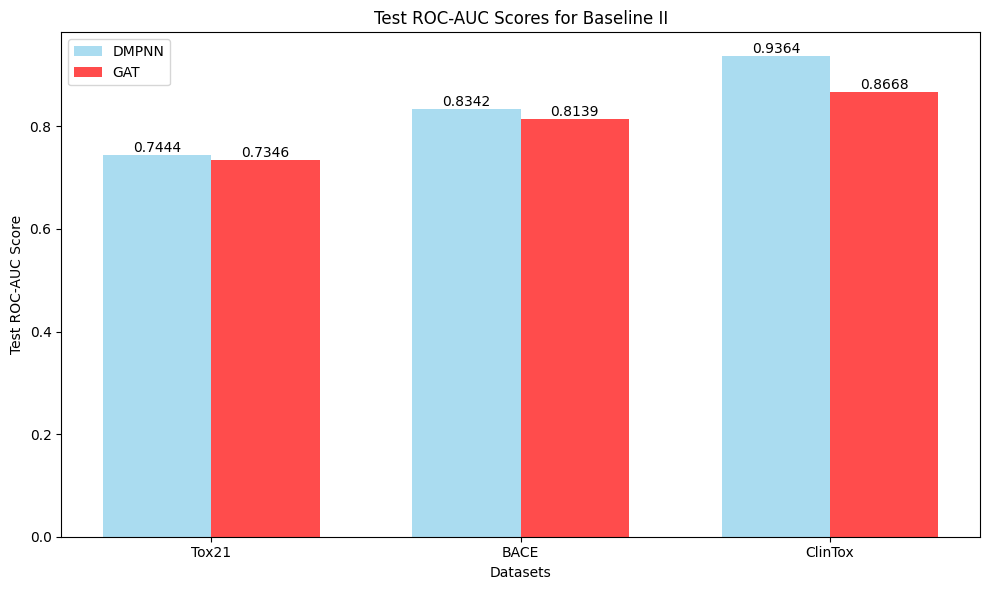

In [92]:
dataset_scores = {}
model_names = set()
for name, score, base_models in results:
    dataset_name = name.split('_')[0]
    model_name = name.split('_')[1]
    model_names.add(model_name)
    if dataset_name not in dataset_scores:
        dataset_scores[dataset_name] = {}
    dataset_scores[dataset_name][model_name] = score

datasets = list(dataset_scores.keys())
dmpnn_scores = [dataset_scores[dataset]['DMPNN'] for dataset in datasets]
gat_scores = [dataset_scores[dataset]['GAT'] for dataset in datasets]

bar_width = 0.35
index = np.arange(len(datasets))

plt.figure(figsize=(10, 6))

bars1 = plt.bar(index, dmpnn_scores, bar_width, label='DMPNN', color='skyblue', alpha=0.7)
bars2 = plt.bar(index + bar_width, gat_scores, bar_width, label='GAT', color='r', alpha=0.7)

plt.xlabel('Datasets')
plt.ylabel('Test ROC-AUC Score')
plt.title('Test ROC-AUC Scores for Baseline II')
plt.xticks(index + bar_width / 2, datasets)
plt.legend(loc='upper left')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


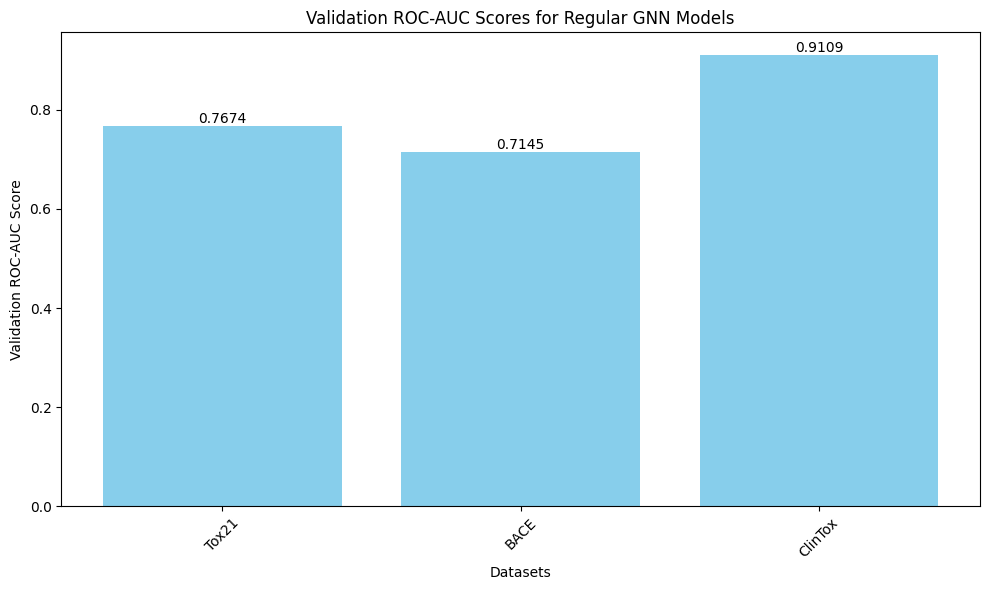

In [62]:
# Extracting the names and their corresponding scores
names_list = [result[0] for result in results]
scores_list = [result[1] for result in results]

# Plotting the results in a bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(names_list, scores_list, color='skyblue')
plt.xlabel('Datasets')
plt.ylabel('Validation ROC-AUC Score')
plt.title('Validation ROC-AUC Scores for Regular GNN Models')
plt.xticks(rotation=45)
plt.tight_layout()

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')


# Display the plot
plt.show()

## RF GNN

After establishing baselines for the datasets, it is time to see the proposed algorithms performance:

In [14]:
num_models_options = [9, 10, 11, 12]
max_num_models = max(num_models_options)

results = []

for i, data in enumerate(loaded_data):
    tasks, datasets, transformers = data
    train, valid, test = datasets
    best_num_models = None
    best_valid_score = float('-inf')
    test_score = None

    models = []
    seed = 42
    frac_train = 0.6

    # Train the maximum number of models once
    for k in range(max_num_models):
        splitter = dc.splits.RandomSplitter()
        train_subset, _ = splitter.train_test_split(train, frac_train=frac_train, seed=seed + k)

        if i == 0:
          train_subgraph_dataset = train_subset
        else:
          train_subset_X = []
          train_subset_y = []
          train_subset_w = []
          train_subset_ids = []

          for idx, sample in enumerate(train_subset.X):
              try:
                  num_nodes = sample.num_nodes
                  if num_nodes < 2:
                      raise ValueError("Not enough nodes to create a subgraph")

                  nodes_to_keep = np.random.choice(num_nodes, size=max(2, num_nodes // 2), replace=False)
                  subgraph_data, _ = sample.subgraph(nodes_to_keep)

                  if subgraph_data.edge_index.shape[1] > 0:  # Ensure there are edges in the subgraph
                      train_subset_X.append(subgraph_data)
                  else:
                      raise ValueError("No edges in subgraph")

              except Exception as e:
                  # If any exception occurs, use the original data
                  train_subset_X.append(sample)

              train_subset_y.append(train_subset.y[idx])
              train_subset_w.append(train_subset.w[idx])
              train_subset_ids.append(train_subset.ids[idx])

          train_subgraph_dataset = dc.data.NumpyDataset(
              X=train_subset_X, y=np.array(train_subset_y), w=np.array(train_subset_w), ids=np.array(train_subset_ids)
          )

        if 'DMPNN' in names[i]:
            model = dc.models.DMPNNModel(
                n_tasks=len(tasks),
                n_classes=2,
                mode='classification',
                batch_size=50,
                global_features_size=200
            )
        elif 'GAT' in names[i]:
            model = dc.models.GATModel(
                n_tasks=len(tasks),
                mode='classification',
                batch_size=50,
                learning_rate=0.001
            )

        model.fit(train_subgraph_dataset, nb_epoch=30)
        models.append(model)

    # This is to not waste and train again n+1 models
    for num_models in num_models_options:
        subset_models = models[:num_models]
        y_pred_proba = random_forest_predict_proba(valid, subset_models, tasks, np.unique(valid.y))
        valid_score = cal_roc_auc_score(valid.y, y_pred_proba)

        if valid_score > best_valid_score:
            best_valid_score = valid_score
            best_num_models = num_models
            y_pred_proba_test = random_forest_predict_proba(test, subset_models, tasks, np.unique(test.y))
            test_score = cal_roc_auc_score(test.y, y_pred_proba_test)

    print(names[i])
    print("Best Number of Models:", best_num_models)
    print("Validation ROC-AUC Score:", best_valid_score)
    print("Test ROC-AUC Score:", test_score)
    results.append((names[i], test_score, best_num_models))

print("Results:")
for name, test_score, best_num_models in results:
    print(f"{name}: Test ROC-AUC Score = {test_score:.4f}, Best Number of Models = {best_num_models}")

Tox21_DMPNN
Best Number of Models: 10
Validation ROC-AUC Score: 0.7683730043825912
Test ROC-AUC Score: 0.7368842653619403
Tox21_GAT
Best Number of Models: 11
Validation ROC-AUC Score: 0.7616305356817042
Test ROC-AUC Score: 0.7299163690227018


KeyboardInterrupt: 

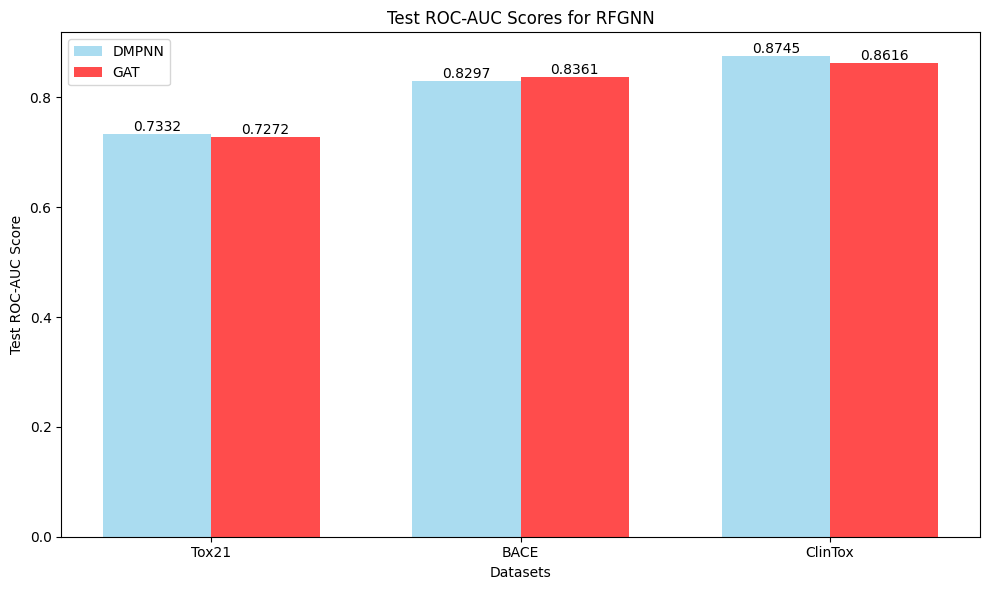

In [13]:
dataset_scores = {}
model_names = set()
for name, score, base_models in results:
    dataset_name = name.split('_')[0]
    model_name = name.split('_')[1]
    model_names.add(model_name)
    if dataset_name not in dataset_scores:
        dataset_scores[dataset_name] = {}
    dataset_scores[dataset_name][model_name] = score

datasets = list(dataset_scores.keys())
dmpnn_scores = [dataset_scores[dataset]['DMPNN'] for dataset in datasets]
gat_scores = [dataset_scores[dataset]['GAT'] for dataset in datasets]

bar_width = 0.35
index = np.arange(len(datasets))

plt.figure(figsize=(10, 6))

bars1 = plt.bar(index, dmpnn_scores, bar_width, label='DMPNN', color='skyblue', alpha=0.7)
bars2 = plt.bar(index + bar_width, gat_scores, bar_width, label='GAT', color='r', alpha=0.7)

plt.xlabel('Datasets')
plt.ylabel('Test ROC-AUC Score')
plt.title('Test ROC-AUC Scores for RFGNN')
plt.xticks(index + bar_width / 2, datasets)
plt.legend(loc='upper left')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


### RF Classifier Reference

In [100]:
#Load Datasets with featurization for Decision Trees:
loaded_data = []
names = []

# Tox21
tox21_tasks, tox21_datasets, tox21_transformers = dc.molnet.load_tox21(
    featurizer=dc.feat.RDKitDescriptors(),
    splitter='scaffold'
)
loaded_data.append((tox21_tasks, tox21_datasets, tox21_transformers))
names.append('Tox21')

#BACE:
BACE_tasks, BACE_datasets, BACE_transformers = dc.molnet.load_bace_classification(
    featurizer=dc.feat.RDKitDescriptors(),
    splitter='scaffold'
)
loaded_data.append((BACE_tasks, BACE_datasets, BACE_transformers))
names.append('BACE')

# ClinTox:
clintox_tasks, clintox_datasets, clintox_transformers = dc.molnet.load_clintox(
    featurizer=dc.feat.RDKitDescriptors(),
    splitter='scaffold'
)
loaded_data.append((clintox_tasks, clintox_datasets, clintox_transformers))
names.append('ClinTox')

In [102]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid

results = []
for i, data in enumerate(loaded_data):
    tasks, datasets, transformers = data
    train, valid, test = datasets

    train_X, train_y = train.X, train.y
    valid_X, valid_y = valid.X, valid.y
    test_X, test_y = test.X, test.y

    train_X = np.nan_to_num(train_X, nan=np.nan, posinf=np.nan, neginf=np.nan)
    valid_X = np.nan_to_num(valid_X, nan=np.nan, posinf=np.nan, neginf=np.nan)
    test_X = np.nan_to_num(test_X, nan=np.nan, posinf=np.nan, neginf=np.nan)

    imputer = SimpleImputer(strategy='mean')
    train_X = imputer.fit_transform(train_X)
    valid_X = imputer.transform(valid_X)
    test_X = imputer.transform(test_X)

    rf_params_dict = {
        'n_estimators': [9, 10, 11, 12, 100, 200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10]
    }

    param_grid = list(ParameterGrid(rf_params_dict))

    best_rf_model = None
    best_rf_params = None
    best_valid_score = 0

    for params in param_grid:
        rf_model = RandomForestClassifier(**params)
        rf_model.fit(train_X, train_y)

        valid_preds = rf_model.predict_proba(valid_X)

        if len(tasks) == 1:  # Single-label classification
            valid_score = roc_auc_score(valid_y, valid_preds[:, 1])
        else:  # Multi-label classification
            roc_auc_scores = []
            for j in range(len(tasks)):
                roc_auc = roc_auc_score(valid_y[:, j], valid_preds[j][:, 1])
                roc_auc_scores.append(roc_auc)
            valid_score = np.mean(roc_auc_scores)

        mean_roc_auc_score = np.mean(roc_auc_scores)

        if mean_roc_auc_score > best_valid_score:
            best_valid_score = mean_roc_auc_score
            best_rf_model = rf_model
            best_rf_params = params

    # Test set evaluation
    test_preds = best_rf_model.predict_proba(test_X)

    if len(tasks) == 1:  # Single-label classification
        test_score = roc_auc_score(test_y, test_preds[:, 1])
    else:  # Multi-label classification
        test_roc_auc_scores = []
        for j in range(len(tasks)):
            test_roc_auc = roc_auc_score(test_y[:, j], test_preds[j][:, 1])
            test_roc_auc_scores.append(test_roc_auc)
        test_score = np.mean(test_roc_auc_scores)

    mean_test_roc_auc_score = np.mean(test_roc_auc_scores)

    print(f"Best RF Hyperparameters for {names[i]}: {best_rf_params}")
    print(f"Validation ROC-AUC Score (RF) for {names[i]}: {best_valid_score}")
    print(f"Test ROC-AUC Score (RF) for {names[i]}: {mean_test_roc_auc_score}")
    results.append((names[i], "Random Forest", best_valid_score, mean_test_roc_auc_score, best_rf_params))

Best RF Hyperparameters for Tox21: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 300}
Validation ROC-AUC Score (RF) for Tox21: 0.7740427048670284
Test ROC-AUC Score (RF) for Tox21: 0.7539771374488762
Best RF Hyperparameters for BACE: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 9}
Validation ROC-AUC Score (RF) for BACE: 0.7740427048670284
Test ROC-AUC Score (RF) for BACE: 0.7539771374488762
Best RF Hyperparameters for ClinTox: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Validation ROC-AUC Score (RF) for ClinTox: 0.8920705081553149
Test ROC-AUC Score (RF) for ClinTox: 0.8979668439161714


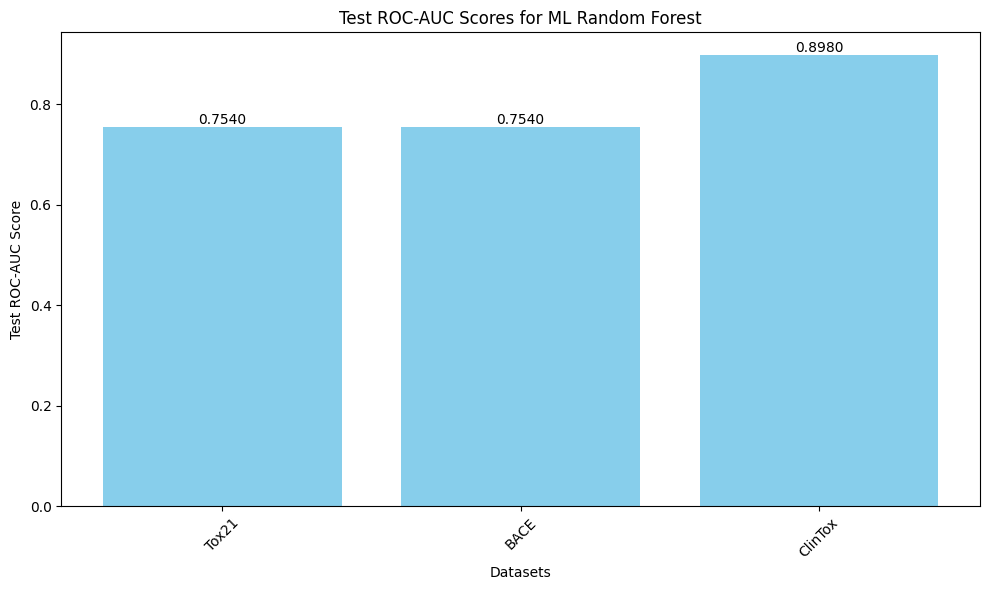

In [110]:
# Extracting the names and their corresponding scores
names_list = [result[0] for result in results]
scores_list = [result[3] for result in results]

plt.figure(figsize=(10, 6))
bars = plt.bar(names_list, scores_list, color='skyblue')
plt.xlabel('Datasets')
plt.ylabel('Test ROC-AUC Score')
plt.title('Test ROC-AUC Scores for ML Random Forest')
plt.xticks(rotation=45)
plt.tight_layout()

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')


# Display the plot
plt.show()